In [1]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
from IPython import display

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
from tqdm import tqdm
import gym
import random
import numpy as np
import time
import os

In [2]:
seed = 543 # Do not change this

def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  #torch.set_deterministic(True)
  torch.set_deterministic(False)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)
    
class PolicyGradientAgent(): 
    def __init__(self, network):
        self.network = network.cuda()
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
         
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        #loss.cuda()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state).cuda())
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])
env = gym.make('LunarLander-v2')

fix(env, seed)
start = time.time()


/home/docker/.local/lib/python3.6/site-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


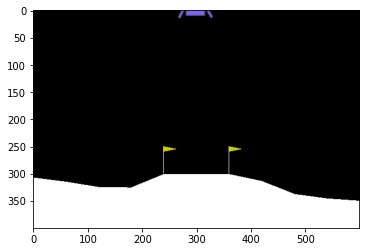

In [3]:
initial_state = env.reset()
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

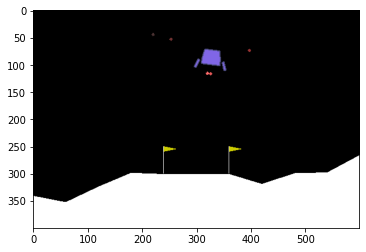

In [4]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
rewwards = list()
done = False
for i in range(50):
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    rewwards.append(reward)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [5]:
rewwards

[-0.4521855097095795,
 -0.4559782871692903,
 -0.3871742238318632,
 -2.1739978181178103,
 -0.4371862754623226,
 -2.6049443042099356,
 -1.1339289422660375,
 2.1311892762762,
 -1.6160319820182565,
 -1.7717472553225662,
 -1.2826135332226898,
 -0.8518127315695085,
 -2.5568520704632065,
 -1.8602239131158456,
 -2.6705234472453285,
 -2.833731381088795,
 2.4505974420328416,
 -2.1269429872625096,
 -2.1358985812530875,
 1.9608097197618803,
 -2.029912910317506,
 -1.181732640670275,
 0.5604273521502818,
 -2.642454610253138,
 -2.860132074999312,
 -1.2169194241383525,
 2.283431672945466,
 0.8544537191608412,
 -1.3901541158511737,
 -1.2743978191074052,
 -1.1870922861185977,
 -2.006465574110591,
 -1.0311650388643432,
 -1.9199545815345107,
 -1.064914451795487,
 -1.970652460891016,
 -0.8333269312585105,
 -1.8910545070199578,
 -0.7903670141545536,
 -0.6374803569379128,
 -1.5436745322004686,
 -0.5421262398675697,
 -0.4288101208127546,
 -1.230548849090012,
 -1.3184102342789277,
 -1.3536519880055085,
 -0.524